In [4]:
# %matplotlib notebook
%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
from _converter import SensorThings2Dict
from _evaluation import print_metrics

_false = "False"
_true = "True"

In [232]:
import json
files = ["ABU1.txt", "ABU1.2.txt"]#
data = []
bad = 0
for filename in files:
    print("Loading rows... {}".format(filename))
    with open(filename) as f:
        for line in f:
            try:
                features = SensorThings2Dict(json.loads(line))
                data.append(list(features.values()))
            except Exception, e:
                bad+=1

print("Incomplete rows: {}".format(bad))
print("Loaded: {}".format(len(data)))

""" random split seed """
data = np.asarray(data)
print("Good: {} Faulty: {}".format(len(data[data[:,-1]==_true]), len(data[data[:,-1]==_false])))
#print(data[:,2:-1])
# numerics = data[:,2:-1]
# for n in numerics[data[:,-1]=='True']:
#     plt.plot(n);
mask = np.random.rand(len(data)) < 0.9

Loading rows... ABU1.txt
Loading rows... ABU1.2.txt
Incomplete rows: 357
Loaded: 83086
Good: 78275 Faulty: 4811


In [127]:
""" split into train and test sets """
train = data[mask]
test = data[~mask]
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))
print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]=='True']), len(test[test[:,-1]=='False']), float(len(test[test[:,-1]=='False']))/len(train)))

faulty = train[train[:,-1]==_false]
not_faulty = train[train[:,-1]==_true]

means = np.mean(not_faulty[:,2:-1].astype(np.float32), axis=0)

Train Total: 27651 Good: 26046 Faulty: 1605 Ratio: 0.0580449170012
Test  Total: 3117 Good: 2937 Faulty: 180 Ratio: 0.00650971031789


In [128]:
""" down/up sample data """
# train = np.concatenate((not_faulty[:len(faulty)*5], faulty))
# samples = np.random.choice(len(not_faulty), 5000, replace=False)
# train = np.concatenate((not_faulty[samples], faulty))
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))

train_data = train[:,2:-1].astype(np.float32)
test_data = test[:,2:-1].astype(np.float32)
"""
Quality_OK is mapped to Faultiness
    'False' -> 1 (Faulty)
    'True'  -> 0 (Good)
"""
train_labels = np.array(train[:,-1]==_false).astype(np.int32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)

Train Total: 27651 Good: 26046 Faulty: 1605 Ratio: 0.0580449170012


In [26]:
""" Train for different feature spaces """
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# ratio = float(len(train[train[:,-1]=='False']))/len(train)
criteria = ["gini", "entropy"]
clf = DecisionTreeClassifier(criterion=criteria[0], random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})
# clf = RandomForestClassifier(n_estimators=10,  class_weight={0:1.0, 1:0.05}, max_depth=90, n_jobs=4)

preds = []
choices = np.arange(30,51+1, 5)
ensemples_per_feature_space = 1
for i,c in enumerate(choices):
    # train multiple trees for each f-space
    for _ in range(ensemples_per_feature_space):
#         r = np.random.choice(c, c*4/5, replace=False)
        r = np.arange(0,c)
        print(r.shape)
        clf.fit(train_data[:,r], train_labels)
        preds.append(clf.predict_proba(test_data[:,r]))
preds = np.asarray(preds)
print(preds.shape)

(51L,)
(1L, 3068L, 2L)


In [201]:
# calculate weight for each tree
weights = (choices/2)-14
print(np.sum(weights))
print(weights)
# take weighted average of predictions
# m = np.average(preds, axis=0, weights=np.repeat(weights, ensemples_per_feature_space, axis=0))
m = preds[-1]
predictions = (m[:,0]<m[:,1]).astype(np.int32)
print_metrics(test_labels, predictions)

29
[ 1  3  6  8 11]
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      2848
          1       0.91      0.97      0.94       201

avg / total       0.99      0.99      0.99      3049

Confusion Matrix:


,0,1
0,2828,20
1,6,195


Matthews Correlation Coefficient: 0.933538703002
--------------------------------------------------------------


In [ ]:
""" Fill remaining features with means """
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100,  class_weight={0:1.0, 1:0.05}, max_depth=90, n_jobs=4)
clf = clf.fit(train_data, train_labels)
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

In [180]:
test_data = data[:,2:-1].astype(np.float32)
test_labels = np.array(data[:,-1]==_false).astype(np.int32)

MCCs = []
CMs = []
Ks = []
# test with partial feature vectors
for x in range(0, 52):
    snapshot = copy.deepcopy(test_data)
    for r in snapshot:
        r[x:] = means[x:]
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(snapshot))
    cm = metrics.confusion_matrix(test_labels, clf.predict(snapshot))
#     k = metrics.cohen_kappa_score(test_labels, clf.predict(snapshot))
    MCCs.append(mcc)
    CMs.append(cm)
#     Ks.append(k)

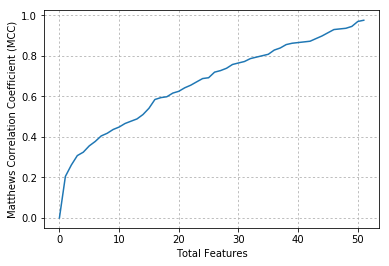

In [167]:
plt.plot(MCCs)
plt.grid(linestyle='dotted')
plt.ylabel("Matthews Correlation Coefficient (MCC)")
plt.xlabel("Total Features")

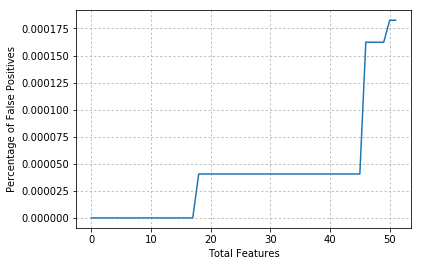

In [181]:
CMs = np.array(CMs)
plt.grid(linestyle='dotted')
plt.ylabel("Percentage of False Positives")
plt.xlabel("Total Features")
plt.plot(CMs[:,0,1]*1.0/CMs[:,0,0])

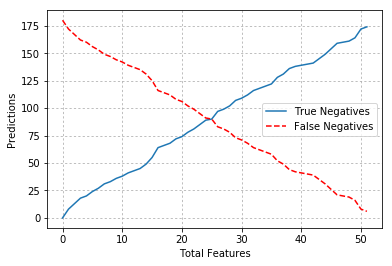

In [168]:
CMs = np.array(CMs)
plt.grid(linestyle='dotted')
plt.ylabel("Predictions")
plt.xlabel("Total Features")

line1, = plt.plot(CMs[:,1,1])
line2, = plt.plot(CMs[:,1,0], color="red", linestyle='--')
plt.legend([line1, line2], ["True Negatives", "False Negatives"])

In [12]:
""" test on JSON data """
feature_data = copy.deepcopy(means)
line = '{"ResultValue": {"total": 7, "measurements": {"bn": "SMTLine/B202/P29063050/", "e": [{"v": 100, "u": "mm", "t": 1481017764434, "n": "ScreenPrinter/PositionX"}, {"v": 200.15, "u": "mm", "t": 1481017764450, "n": "ScreenPrinter/PositionY"}, {"v": 42.92, "u": "mm", "t": 1481017776092, "n": "PasteInspection/PosX1"}, {"v": 21.95, "u": "mm", "t": 1481017776108, "n": "PasteInspection/PosY1"}, {"v": 31.84, "u": "mm", "t": 1481017776109, "n": "PasteInspection/PosX2"}, {"v": 54.96, "u": "mm", "t": 1481017776109, "n": "PasteInspection/PosY2"}, {"v": 20.92, "u": "mm", "t": 1481017776109, "n": "PasteInspection/PosX3"}]}, "type": {"bt": 2297529600, "bn": "SMTLine/B202/P29063050/", "e": [{"t": 1481017712576, "sv": "ABU2", "n": "Source/ProdType"}]}}}'
features = SensorThings2Dict(line, complete=False)
# convert measurements to numpy array
r = np.asarray(features.values())[2:-1].astype(np.float32)
# fill nans with global means
w = np.where(np.isnan(r))
r[w] = means[w]
clf.predict(r)

C:\Users\Farshid\Anaconda2\envs\python2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

In [233]:
""" calculate aggregates for graphs """

good = np.asarray(data[data[:,-1]==_true])
good = good[:,2:-1].astype(np.float32)
print good.shape
std1 = np.std(good, axis=0)
min1 = np.min(good, axis=0)
max1 = np.max(good, axis=0)
mean1 = np.mean(good, axis=0)

bad = np.asarray(data[data[:,-1]==_false])
bad = bad[:,2:-1].astype(np.float32)
print bad.shape
std2 = np.std(bad, axis=0)
min2 = np.min(bad, axis=0)
max2 = np.max(bad, axis=0)
mean2 = np.mean(bad, axis=0)

print np.average(sigma1)
print np.average(sigma2)

(78275L, 51L)
(4811L, 51L)
0.847439
0.925939


In [257]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', quality=100)
plt.grid(linestyle='dotted')
plt.ylabel("Standard Deviation")
plt.xlabel("Feature Number")

# plt.plot((mean1-mean2)**2)
line1, = plt.plot(std1, color="green")
line2, = plt.plot(std2, color="red", linestyle='--')
plt.legend([line1, line2], ["Non Defects $\sigma_1$", "Defects $\sigma_2$"])

In [258]:
plt.grid(linestyle='dotted')

plt.xlabel("Feature Number")
line, = plt.plot((std2-std1), color="black")
plt.legend([line], [r"$\sigma_1-\sigma_0$"], loc=2)

(-10, 310)

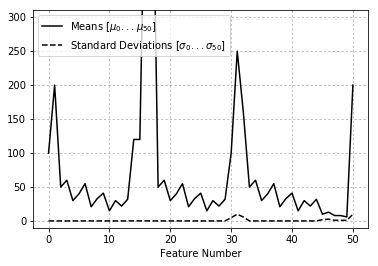

In [245]:
plt.grid(linestyle='dotted')

plt.xlabel("Feature Number")


line1, = plt.plot(mean1, color="black")
line2, = plt.plot(std1, color="black", linestyle='--')
plt.legend([line1, line2], ["Means $[\mu_0 ... \mu_{50}]$", "Standard Deviations $[\sigma_0 ... \sigma_{50}]$"])
plt.ylim((-10,310))